# Setting

In [1]:
import bt
import FinanceDataReader as fdr
import pandas as pd

from pf_utils import convert_rate_to_price
from pf_utils import Backtest, get_date_range, metrics, AssetEvaluator

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'

In [3]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

## testing

In [4]:
import bt
import pandas as pd
import matplotlib.pyplot as plt

import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt

metrics = [
    'total_return', 'cagr', 
    'max_drawdown', 'avg_drawdown', 'avg_drawdown_days', 
    'daily_mean', 'daily_vol','daily_sharpe', #'daily_sortino', 
    'monthly_mean', 'monthly_vol', 'monthly_sharpe', #'monthly_sortino'
]

WEEKS_IN_YEAR = 51


def import_rate1(file, path='.', cols=['date', None]):
    """
    file: historical of cumulative rate of return in long format
    data_check: [(기준일1, 기준가1), (기준일2, 기준가2)]
    """
    df_rate = pd.read_csv(f'{path}/{file}', parse_dates=[0], index_col=[0])
    if df_rate.columns.size > 1:
        print('WARNING: taking the 1st two columns only.')
    # make sure to get series
    df_rate = df_rate.iloc[:, 0]
    df_rate = df_rate.rename_axis(cols[0])
    
    col_data = cols[1]
    if col_data is None:
        col_data = file.split('.')[0]
    df_rate.name = col_data

    return df_rate


def import_rate2(file, path='.', cols=['date', None], n_headers=1):
    """
    file: historical of cumulative rate of return in wide format
    data_check: [(기준일1, 기준가1), (기준일2, 기준가2)]
    """
    df_rate = pd.read_csv(f'{path}/{file}')
    df_rate = df_rate.T.iloc[n_headers:, 0]

    df_rate.index = pd.to_datetime(df_rate.index)
    df_rate = df_rate.rename_axis(cols[0])
    
    col_data = cols[1]
    if col_data is None:
        col_data = file.split('.')[0]
    df_rate.name = col_data

    return df_rate
    

def get_price(df_rate, data_check, rate_is_percent=True):
    """
    calc price from rate of return
    """
    # date check
    for dt, _ in data_check:
        try:
            dt = pd.to_datetime(dt)
            rate = df_rate.loc[dt]
        except KeyError as e:
            return print(f'ERROR: KeyError {e}')
    
    # convert to price with data_check[0]
    dt, price = data_check[0]
    dt = pd.to_datetime(dt)
    rate = df_rate.loc[dt]
    if rate_is_percent:
        rate = rate/100
        df_rate = df_rate/100
    price_base = price / (rate+1)
    df_price = (df_rate + 1) * price_base 

    # check price
    dt, price = data_check[1]
    e = df_price.loc[dt]/price - 1
    print(f'error: {e*100:.2f} %')
    
    return df_price


def convert_rate_to_price(data, n_headers=1, path=None, 
                          rate_is_percent=True, df_rate=None, rate_only=False):
    """
    data: series or dict
    df_rate: historical given as dataframe
    """
    data_type = data['data_type']
    if data_type == 1:
        import_rate = import_rate1
    elif data_type == 2:
        import_rate = lambda *args, **kwargs: import_rate2(*args, n_headers=n_headers, **kwargs)
    else:
        if df_rate is None:
            return print(f'ERROR: no data type {data_type} exists')
        else:
            import_rate = lambda *args, **kwargs: df_rate.rename_axis(kwargs['cols'][0]).rename(kwargs['cols'][1])
    
    ticker = data['ticker']
    name = data['name']
    file = f'{data['file']}.csv'
    data_check = [
        (data['check1_date'], data['check1_price']),
        (data['check2_date'], data['check2_price']),
    ]
    
    df = import_rate(file, path=path, cols=['date', ticker])
    if rate_only:
       return df
        
    df = get_price(df, data_check, rate_is_percent=rate_is_percent)
    if df is None:
        return print(f'ERROR: check {ticker}')
    else:
        return df


def get_date_range(dfs, symbol_name=None, slice_input=False):
    """
    symbol_name: dict of symbols to names
    """
    df = dfs.apply(lambda x: x[x.notna()].index.min()).to_frame('start date')
    df = df.join(dfs.apply(lambda x: x[x.notna()].index.max()).to_frame('end date'))
    if symbol_name is not None:
        df = pd.Series(symbol_name).to_frame('name').join(df)

    if slice_input:
        start_date = df.iloc[:, 0].max()
        end_date = df.iloc[:, 1].min()
        return dfs.loc[start_date:end_date]
    else:
        return df.sort_values('start date')



def valuate_bond(face, rate, year, ytm, n_pay=1):
    """
    face: face value
    rate: coupon rate (annual)
    year: years to maturity
    ytm: discount rate (annual)
    n_pay: number of payments per year
    """
    c = face * rate / n_pay
    vc = 0
    r_discount = ytm/n_pay
    # calc The present value of expected cash flows
    for t in range(1, year*n_pay+1):
        vc += c/(1+r_discount)**t
    # the present value of the face value of the bond added
    return vc + face/(1+r_discount)**(year*n_pay)





### class

In [15]:
class Backtest():
    """
    backtest fixed weight portfolio
    """
    def __init__(self, df_equity, metrics=None, name_prfx='Portfolio', 
                 initial_capital=1000000, commissions=None, equity_names=None):
        self.df_equity = df_equity
        self.portfolios = dict()
        self.pf_weights = dict()
        self.metrics = metrics
        self.name_prfx = name_prfx
        self.n_names = 0 # see self._check_name
        self.initial_capital = initial_capital
        # commissions of all equities across portfolios (per year)
        self.commissions = commissions 
        self.equity_names = equity_names # names of all equities across portfolios
        self.run_results = None


    def align_period(self, df_equity, dt_format='%Y-%m-%d', n_indent=2, fill_na=True):
        """
        fill_na: set False to drop nan fields
        """
        df = get_date_range(df_equity, slice_input=True)
        dts = [x.strftime(dt_format) for x in (df.index.min(), df.index.max())]
        print(f"period reset: {' ~ '.join(dts)}")
        
        stats = df.isna().sum().div(df.count())
        t = 'filled forward' if fill_na else 'dropped'
        print(f'ratio of nan {t}::')
        indent = ' '*n_indent
        _ = [print(f'{indent}{i}: {stats[i]:.3f}') for i in stats.index]

        if fill_na:
            return df.ffill()
        else:
            return df.dropna()
        
    
    def _check_name(self, name=None):
        if name is None:
            self.n_names += 1
            name = f'{self.name_prfx} {self.n_names}'
        return name

    
    def _check_weights(self, dfs, weights):
        if weights is None:
            cols = dfs.columns
            weights = dict(zip(cols, [1/len(cols)]*len(cols)))
        return weights

    
    def _check_var(self, var_arg, var_self):
        if var_arg is None:
            var_arg = var_self
        return var_arg


    def _calc_commissions(self, commissions, weights, freq='Y', rate_is_percent=True):
        """
        commissions: dict of equity to fee
        """
        a = 100 if rate_is_percent else 1
        
        if freq == 'W':
            a *= 52
        elif freq == 'Q':
            a *= 4
        elif freq == 'M':
            a *= 12
        else:
            pass

        try:
            c = sum([v*commissions[k]/a for k,v in weights.items()])
            return lambda q, p: abs(q*p*c)
        except Exception as e:
            print(f'WARNING: commissions set to 0 as {e}')
            return None


    def backtest(self, dfs, weights=None, name='portfolio', 
                 run_freq=bt.algos.RunOnce(), 
                 capital_flow=0, **kwargs):
        """
        kwargs: keyword args for bt.Backtest
        """
        strategy = bt.Strategy(name, [
            bt.algos.SelectAll(),
            bt.algos.CapitalFlow(capital_flow),
            bt.algos.WeighSpecified(**weights),
            run_freq,
            bt.algos.Rebalance()
        ])
        return bt.Backtest(strategy, dfs, **kwargs)
        

    def build(self, weights=None, name=None, freq=None, 
              initial_capital=None, commissions=None, capital_flow=0,
              fill_na=True):
        """
        make backtest of a strategy with tickers in weights
        """
        dfs = self.df_equity
        weights = self._check_weights(dfs, weights)
        name = self._check_name(name)
        initial_capital = self._check_var(initial_capital, self.initial_capital)
        
        try:
            dfs = dfs[weights.keys()] # dataframe even if one weight given
        except KeyError as e:
            return print(f'ERROR: check weights as {e}')

        dfs = self.align_period(dfs, fill_na=fill_na)
                
        if freq == 'W':
            run_freq = bt.algos.RunWeekly()
        elif freq == 'Q':
            run_freq = bt.algos.RunQuarterly()
        elif freq == 'Y':
            run_freq = bt.algos.RunYearly()
        elif freq == 'M':
            run_freq = bt.algos.RunMonthly()
        else: # default: buy & hold
            run_freq = bt.algos.RunOnce()
        
        commissions = self._check_var(commissions, self.commissions)
        if commissions is None:
            c_avg = None
        else:
            c_avg = self._calc_commissions(commissions, weights, freq)
        
        self.portfolios[name] = self.backtest(dfs, weights=weights, name=name, run_freq=run_freq, 
                                              capital_flow=capital_flow,
                                              initial_capital=initial_capital, commissions=c_avg)
        self.pf_weights[name] = weights
        return None

    
    def buy_n_hold(self, weights=None, name=None, **kwargs):
        if isinstance(weights, str):
            weights = {weights: 1}
        return self.build(weights=weights, name=name, freq=None, **kwargs)


    def build_batch(self, kwa_list, reset_portfolios=False, **kwargs):
        """
        kwa_list: list of k/w args for each backtest
        kwargs: k/w args common for all backtest
        """
        if reset_portfolios:
            self.portfolios = {}
        else:
            return print('WARNING: set reset_portfolios to True to run')

        for kwa in kwa_list:
            self.build(**{**kwa, **kwargs})
        return None

    
    def run(self, pf_list=None, metrics=None, plot=True, freq='d', figsize=None, stats=True):
        """
        pf_list: List of backtests or list of index of backtest
        """
        if len(self.portfolios) == 0:
            return print('ERROR: no strategy to backtest. build strategies first')
            
        if pf_list is None:
            bt_list = self.portfolios.values()
        else:
            c = [0 if isinstance(x, int) else 1 for x in pf_list]
            if sum(c) == 0: # pf_list is list of index
                bt_list = [x for i, x in enumerate(self.portfolios.values()) if i in pf_list]
            else: # pf_list is list of names
                bt_list = [v for k, v in self.portfolios.items() if k in pf_list]

        try:
            results = bt.run(*bt_list)
        except Exception as e:
            return print(f'ERROR: {e}')
            
        self.run_results = results
        
        if plot:
            results.plot(freq=freq, figsize=figsize);

        if stats:
            metrics = self._check_var(metrics, self.metrics)
            if (metrics is None) or (metrics == 'all'):
                return results.stats
            else:
                metrics = ['start', 'end'] + metrics
                return results.stats.loc[metrics]
        else:
            return results


    def check_portfolios(self, pf_list=None, run=True, convert_index=True):
        """
        convert_index: convert pf_list of index to pf_list of portfolio names 
        """
        if run:
            if self.run_results is None:
                return print('ERROR: run backtest first')
            else:
                pf_list_all = list(self.run_results.keys())
        else:
            pf_list_all = list(self.portfolios.keys())
    
        if pf_list is None:
            return pf_list_all
            
        if not isinstance(pf_list, list):
            pf_list = [pf_list]
    
        try: # assuming list of int
            if max(pf_list) >= len(pf_list_all):
                print('WARNING: check pf_list')
                pf_list = pf_list_all
            else:
                if convert_index:
                    pf_list = [pf_list_all[x] for x in pf_list]

        except TypeError: # pf_list is list of str
            if len(set(pf_list) - set(pf_list_all)) > 0:
                print('WARNING: check pf_list')
                pf_list = pf_list_all
            
        return pf_list


    def _plot_portfolios(self, plot_func, pf_list, ncols=2, sharex=True, sharey=True, figsize=(10,5)):
        n = len(pf_list)
        nrows = n // ncols + min(n % ncols, 1)
        fig, axs = plt.subplots(nrows, ncols, sharex=sharex, sharey=sharey,
                                #figsize=figsize
                               )
        if nrows == 1:
            axs = [axs]
        
        k = 0
        finished = False
        for i in range(nrows):
            for j in range(ncols):
                ax = axs[i][j]
                _ = plot_func(pf_list[k], ax=ax, figsize=figsize)
                k += 1
                if k == n:
                    finished = True
                    break
            if finished:
                break
    
    
    def plot_security_weights(self, pf_list=None, **kwargs):
        pf_list  = self.check_portfolios(pf_list, run=True)
        if pf_list is None:
            return None
        
        plot_func = self.run_results.plot_security_weights
        return self._plot_portfolios(plot_func, pf_list, **kwargs)
        

    def plot_weights(self, pf_list=None, **kwargs):
        pf_list  = self.check_portfolios(pf_list, run=True)
        if pf_list is None:
            return None
        
        plot_func = self.run_results.plot_weights
        return self._plot_portfolios(plot_func, pf_list, **kwargs)


    def plot_histogram(self, pf_list=None, **kwargs):
        pf_list  = self.check_portfolios(pf_list, run=True)
        if pf_list is None:
            return None
        
        if len(pf_list) > 1:
            print('WARNING: passed axis not bound to passed figure')

        for x in pf_list:
            _ = self.run_results.plot_histogram(x, **kwargs)
        return None


    def get_weights(self, pf_list=None, equity_names=None, as_series=True):
        pf_list  = self.check_portfolios(pf_list, run=False, convert_index=True)
        if pf_list is None:
            return None
        
        weights = {k: self.pf_weights[k] for k in pf_list}
        quity_names = self._check_var(equity_names, self.equity_names)
        if equity_names is not None:
            weights = {k: {equity_names[x]:y for x,y in v.items()} for k,v in weights.items()}
        if as_series:
            weights = pd.DataFrame().from_dict(weights).fillna(0)
        return weights


    def get_historical(self, pf_list=None, normalize=True):
        """
        calc weighted sum of securities for each portfolio
        """
        pf_list  = self.check_portfolios(pf_list, run=True, convert_index=True)
        if pf_list is None:
            return None

        df_all = None
        for rp in pf_list:
            df = self._calc_weigthed(self.portfolios[rp])
            if normalize:
                df = df / df.dropna().iloc[0] * 100
            if df_all is None:
                df_all = df
            else:
                df_all = df_all.join(df)
        return df_all
        

    def _calc_weigthed(self, result_portfolio):
        df_d = result_portfolio.data
        df_w = result_portfolio.weights
        cols_d = df_d.columns
        cols_w = df_w.columns
        col_p = cols_w[0]
        
        di = list(range(len(cols_d)))
        wi = [[i+len(di) for i, cw in enumerate(cols_w) if cw.endswith(cd)][0] for cd in cols_d]
        f = lambda la, lb: [la[i] for i in lb]
        return (df_d.join(df_w, rsuffix='_w')
                    .apply(lambda x: np.inner(f(x, di), f(x, wi)), axis=1)
                    .to_frame(col_p).dropna())



class AssetEvaluator():
    def __init__(self, df_prices, days_in_year=252):
        df_prices = df_prices.to_frame() if isinstance(df_prices, pd.Series) else df_prices
        if df_prices.index.name is None:
            df_prices.index.name = 'date' # set index name to run check_days_in_year
        _ = self.check_days_in_year(df_prices, days_in_year, freq='M')
        
        self.df_prices = df_prices
        self.days_in_year = days_in_year
        self.bayesian_data = None
        

    def check_days_in_year(self, df, days_in_year, freq='M'):
        """
        freq: freq to check days_in_year in df
        """
        if freq == 'Y':
            grp_format = '%Y'
            #days_in_freq = days_in_year
            factor = 1
        elif freq == 'W':
            grp_format = '%Y%m%U'
            #days_in_freq = round(days_in_year/12/WEEKS_IN_YEAR)
            factor = 12 * WEEKS_IN_YEAR
        else: # default month
            grp_format = '%Y%m'
            #days_in_freq = round(days_in_year/12)
            factor = 12
        
        df_freq = (pd.Series(1, index=df.index.strftime(grp_format))
                     .groupby(df.index.name).count())
        df_freq = df_freq[1:-1]
        if len(df_freq) == 0:
            print(f'ERROR: set freq less than {freq}')
            return days_in_year
        
        days_freq_calc = round(df_freq.mean())
        if days_freq_calc != round(days_in_year / factor):
            days_in_year_new = round(days_freq_calc * factor)
            print(f'WARNING: the num of days in a year is {days_in_year_new} different with {days_in_year} in setting')
            return days_in_year_new
        else:
            return days_in_year


    def get_freq_days(self, freq='daily'):
        if freq == 'yearly':
            n = self.days_in_year
        elif freq == 'monthly':
            n = round(self.days_in_year/12)
        elif freq == 'weekly':
            n = round(self.days_in_year/WEEKS_IN_YEAR)
        else: # default daily
            n = 1
            freq = 'daily'
        return (n, freq)

        
    def _check_var(self, var_arg, var_self):
        if var_arg is None:
            var_arg = var_self
        return var_arg

    
    def calc_cagr(self, df_prices=None, days_in_year=None):
        df_prices = self._check_var(df_prices, self.df_prices)
        days_in_year = self._check_var(days_in_year, self.days_in_year)

        t = days_in_year / len(df_prices)
        cagr = lambda x: (x[-1]/x[0]) ** t -1
        
        return df_prices.apply(lambda x: cagr(x.dropna()))
        

    def calc_mean_return(self, df_prices=None, days_in_year=None, freq='daily', annualize=True):
        df_prices = self._check_var(df_prices, self.df_prices)
        days_in_year = self._check_var(days_in_year, self.days_in_year)

        periods, _ = self.get_freq_days(freq)
        res = df_prices.pct_change(periods).dropna().mean()
        if annualize:
            return res * (days_in_year/periods)
        else:
            return res
        

    def calc_volatility(self, df_prices=None, days_in_year=None, freq='daily', annualize=True):
        df_prices = self._check_var(df_prices, self.df_prices)
        days_in_year = self._check_var(days_in_year, self.days_in_year)

        periods, _ = self.get_freq_days(freq)
        res = df_prices.pct_change(periods).dropna()
        res = res.std()
        if annualize:
            return res * ((days_in_year/periods) ** .5)
        else:
            return res


    def calc_sharpe(self, df_prices=None, days_in_year=None, freq='daily', annualize=True, rf=0):
        df_prices = self._check_var(df_prices, self.df_prices)
        days_in_year = self._check_var(days_in_year, self.days_in_year)

        periods, _ = self.get_freq_days(freq)
        res = df_prices.pct_change(periods).dropna()
        res = (res.mean() - rf) / res.std()
        if annualize:
            return res * ((days_in_year/periods) ** .5)
        else:
            return res


    def summary(self, freq='yearly', annualize=True, rf=0, align_period=False):
        df_prices = self.df_prices
        if align_period:
            df_prices = self.align_period(df_prices, fill_na=False)

        _, freq = self.get_freq_days(freq) # check freq for naming
        kwargs = dict(
            df_prices=df_prices, freq=freq, annualize=annualize
        )
        df = df_prices.apply(lambda x: f'{len(x.dropna())/self.days_in_year:.1f}')
        # work even with df_prices of single asset as df_prices is always series (see __init__)
        return df.to_frame('years').join(
            self.calc_cagr(df_prices).to_frame('cagr').join(
                self.calc_mean_return(**kwargs).to_frame(f'{freq}_mean').join(
                    self.calc_volatility(**kwargs).to_frame(f'{freq}_vol').join(
                        self.calc_sharpe(rf=rf, **kwargs).to_frame(f'{freq}_sharpe')
                    )
                )
            )
        ).T


    def bayesian_sample(self, freq='yearly', annualize=True, rf=0, align_period=False,
                        sample_draws=1000, sample_tune=1000, target_accept=0.9,
                        multiplier_std=10):

        self.bayesian_sample_warning(freq)

        days_in_year = self.days_in_year
        periods, freq = self.get_freq_days(freq)
        factor_year = days_in_year/periods if annualize else 1

        df_prices = self.df_prices
        assets = list(df_prices.columns)
        
        if align_period:
            df_prices = self.align_period(df_prices, fill_na=False)
            df_ret = df_prices.pct_change(periods).dropna()
            mean_prior = df_ret.mean()
            std_prior = df_ret.std()
            std_low = std_prior / multiplier_std
            std_high = std_prior * multiplier_std
        else:
            ret_list = [df_prices[x].pct_change(periods).dropna() for x in assets]
            mean_prior = [x.mean() for x in ret_list]
            std_prior = [x.std() for x in ret_list]
            std_low = [x / multiplier_std for x in std_prior]
            std_high = [x * multiplier_std for x in std_prior]
            returns = dict()
        
        num_assets = len(assets) # flag for comparisson of two assets
        coords={'asset': assets}

        with pm.Model(coords=coords) as model:
            nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
            #nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29.0)
            #nu = pm.Deterministic("nu", nu_minus_one + 1)
            
            mean = pm.Normal('mean', mu=mean_prior, sigma=std_prior, dims='asset')
            std = pm.Uniform('std', lower=std_low, upper=std_high, dims='asset')
            if align_period:
                returns = pm.StudentT('returns', nu=nu, mu=mean, sigma=std, observed=df_ret)
            else:
                func = lambda x: dict(mu=mean[x], sigma=std[x], observed=ret_list[x])
                returns = {i: pm.StudentT(f'returns[{i}]', nu=nu, **func(i)) for i, _ in enumerate(assets)}
            
            std = std * pt.sqrt(nu / (nu - 2))
            pm.Deterministic(f'{freq}_mean',  mean * factor_year, dims='asset')
            pm.Deterministic(f'{freq}_vol',  std * (factor_year ** .5), dims='asset')
            pm.Deterministic(f'{freq}_sharpe', ((mean-rf) / std) * (factor_year ** .5), dims='asset')
    
            if num_assets == 2:
                mean_diff = pm.Deterministic('mean diff', mean[0] - mean[1])
                pm.Deterministic('std diff', std[0] - std[1])
                pm.Deterministic('effect size', mean_diff / (std[0] ** 2 + std[1] ** 2) ** .5 / 2)
    
            trace = pm.sample(draws=sample_draws, tune=sample_tune,
                              #chains=chains, cores=cores,
                              target_accept=target_accept,
                              #return_inferencedata=False, # TODO: what's for?
                              progressbar=True)
            
        self.bayesian_data = {'trace':trace, 'coords':coords, 
                              'freq':freq, 'annualize':annualize, 'rf':rf}
        return None


    
    def bayesian_sample_working(self, freq='yearly', annualize=True, rf=0, align_period=False,
                        sample_draws=1000, sample_tune=1000, target_accept=0.9,
                        multiplier_std=10):

        self.bayesian_sample_warning(freq)

        days_in_year = self.days_in_year
        periods, freq = self.get_freq_days(freq)
        factor_year = days_in_year/periods if annualize else 1
        
        df_prices = self.df_prices
        if align_period:
            df_prices = self.align_period(df_prices, fill_na=False)
        df_ret = df_prices.pct_change(periods)

        mean, std, returns = {}, {}, {}
        assets = list(df_ret.columns)
        num_assets = len(assets) # flag for comparisson of two assets
        with pm.Model() as model:
            nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
            
            for i, x in enumerate(assets):
                mean[i] = pm.Normal(f'mean[{x}]', mu=mean_prior, sigma=std_prior)
                std[i] = pm.Uniform(f'std[{x}]', lower=std_low, upper=std_high)
                returns[i] = pm.StudentT('returns', nu=nu, mu=mean, sigma=std, observed=df_ret)




        ###
        
        mean_prior = df_ret.mean()
        std_prior = df_ret.std()
        std_low = std_prior / multiplier_std
        std_high = std_prior * multiplier_std
        factor_year = days_in_year/periods if annualize else 1
    
        assets = list(df_ret.columns)
        num_assets = len(assets) # flag for comparisson of two assets
        coords={'asset': assets}
        
        with pm.Model() as model:
            nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
            
            mean = pm.Normal('mean', mu=mean_prior, sigma=std_prior)
            std = pm.Uniform('std', lower=std_low, upper=std_high)
            returns = pm.StudentT('returns', nu=nu, mu=mean, sigma=std, observed=df_ret)
            
            std = std * pt.sqrt(nu / (nu - 2))
            pm.Deterministic(f'{freq}_mean',  mean * factor_year, dims='asset')
            pm.Deterministic(f'{freq}_vol',  std * (factor_year ** .5), dims='asset')
            pm.Deterministic(f'{freq}_sharpe', ((mean-rf) / std) * (factor_year ** .5), dims='asset')
    
            if num_assets == 2:
                mean_diff = pm.Deterministic('mean diff', mean[0] - mean[1])
                pm.Deterministic('std diff', std[0] - std[1])
                pm.Deterministic('effect size', mean_diff / (std[0] ** 2 + std[1] ** 2) ** .5 / 2)
    
            trace = pm.sample(draws=sample_draws, tune=sample_tune,
                              #chains=chains, cores=cores,
                              target_accept=target_accept,
                              #return_inferencedata=False, # TODO: what's for?
                              progressbar=True)
            
        self.bayesian_data = {'trace':trace, 'coords':coords, 
                              'freq':freq, 'annualize':annualize, 'rf':rf}
        return None


    def bayesian_sample_old(self, freq='yearly', annualize=True, rf=0,
                        sample_draws=1000, sample_tune=1000, target_accept=0.9,
                        multiplier_std=10):

        self.bayesian_sample_warning(freq)

        days_in_year = self.days_in_year
        periods, freq = self.get_freq_days(freq)

        #df_ret = self.df_prices.pct_change(periods) # ImputationWarning & taking more time
        #df_ret = self.df_prices.pct_change(periods).dropna()
        df_ret = self.align_period(self.df_prices, fill_na=False)
        df_ret = df_ret.pct_change(periods).dropna()
        
        mean_prior = df_ret.mean()
        std_prior = df_ret.std()
        std_low = std_prior / multiplier_std
        std_high = std_prior * multiplier_std
        factor_year = days_in_year/periods if annualize else 1
    
        assets = list(df_ret.columns)
        num_assets = len(assets) # flag for comparisson of two assets
        coords={'asset': assets}
        
        with pm.Model(coords=coords) as model:
            nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
            
            #nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29.0)
            #nu = pm.Deterministic("nu", nu_minus_one + 1)
            
            mean = pm.Normal('mean', mu=mean_prior, sigma=std_prior, dims='asset')
            std = pm.Uniform('std', lower=std_low, upper=std_high, dims='asset')
            returns = pm.StudentT('returns', nu=nu, mu=mean, sigma=std, observed=df_ret)
            
            std = std * pt.sqrt(nu / (nu - 2))
            pm.Deterministic(f'{freq}_mean',  mean * factor_year, dims='asset')
            pm.Deterministic(f'{freq}_vol',  std * (factor_year ** .5), dims='asset')
            pm.Deterministic(f'{freq}_sharpe', ((mean-rf) / std) * (factor_year ** .5), dims='asset')
    
            if num_assets == 2:
                mean_diff = pm.Deterministic('mean diff', mean[0] - mean[1])
                pm.Deterministic('std diff', std[0] - std[1])
                pm.Deterministic('effect size', mean_diff / (std[0] ** 2 + std[1] ** 2) ** .5 / 2)
    
            trace = pm.sample(draws=sample_draws, tune=sample_tune,
                              #chains=chains, cores=cores,
                              target_accept=target_accept,
                              #return_inferencedata=False, # TODO: what's for?
                              progressbar=True)
            
        self.bayesian_data = {'trace':trace, 'coords':coords, 
                              'freq':freq, 'annualize':annualize, 'rf':rf}
        return None
        
    
    def bayesian_summary(self, var_names=None, filter_vars='like', **kwargs):
        if self.bayesian_data is None:
            return print('ERROR: run bayesian_sample first')
        else:
            trace = self.bayesian_data['trace']
            return az.summary(trace, var_names=var_names, filter_vars=filter_vars, **kwargs)


    def bayesian_plot(self, var_names=None, filter_vars='like', **kwargs):
        if self.bayesian_data is None:
            return print('ERROR: run bayesian_sample first')
        else:
            trace = self.bayesian_data['trace']
            coords = self.bayesian_data['coords']
            freq = self.bayesian_data['freq']
            annualize = self.bayesian_data['annualize']
            rf = self.bayesian_data['rf']

        df = self.summary(freq=freq, annualize=annualize, rf=rf)
        metrics = [x for x in df.index if x.startswith(freq)]
        ref_val = df.loc[metrics].to_dict(orient='index')
        col_name = list(coords.keys())[0]
        ref_val = {k: [{col_name:at, 'ref_val':rv} for at, rv in v.items()] for k,v in ref_val.items()}
            
        _ = az.plot_posterior(trace, var_names=var_names, filter_vars=filter_vars,
                              ref_val=ref_val, **kwargs)
        return None


    def align_period(self, df, fill_na=False):
        return Backtest(pd.Series()).align_period(df, fill_na=fill_na)


    def bayesian_sample_warning(self, freq='yearly'):
        msg = """ 
        Bayesian estimation of certain TDFs yielded dubious posteriors for daily or monthly frequencies. 
        However, the estimation for some ETFs appeared reasonable. The issue might lie in the historical prices of TDFs, 
        which were derived from cumulative rates of return, with data for weekends seemingly filled forward.
        """
        if freq != 'yearly':
            return print(f'WARNING: {msg}')
        else:
            return None

### test

# Data

## TDF
- https://www.kiwoomam.com/fund/KI0202020000M?parentfundcode=8325&fundcode=8335
- https://investments.miraeasset.com/fund/view.do?fundGb=2&fundCd=537380&childFundGb=2&childFundCd=53738P
- https://www.hanwhawm.com/main/finance/fundInfo/FI141_2.cmd?p=500&item_cd=5102896

In [6]:
file = '금융자산운용 - export.csv'
df_info = pd.read_csv(f'{path_data}/{file}')

In [7]:
tdf_names = df_info.set_index('ticker')['name'].to_dict()
commissions = df_info.set_index('ticker')['commission'].to_dict()
{tdf_names[k]:v for k,v in commissions.items()}

{'미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e': 0.6,
 '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)': 0.48,
 '미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e': 0.54,
 '미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e': 0.74,
 '키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)': 0.68,
 'KODEX 미국S&P500TR assumed from S&P500 rate of return': 0.0}

In [8]:
df_info = df_info.iloc[:-1]
df_tdfs = None

for _, data in df_info.iterrows():
    df = convert_rate_to_price(data, path=path_data)
    
    if df_tdfs is None:
        df_tdfs = df.to_frame()
    else:
        df_tdfs = df_tdfs.join(df, how='outer')

error: -0.07 %
error: -0.00 %
error: 0.16 %
error: -0.13 %
error: 0.00 %


In [9]:
get_date_range(df_tdfs)

,start date,end date
K55301BU5479,2017-08-14,2024-06-16
K55301BU6139,2017-09-20,2024-06-16
K55301BU5453,2017-09-29,2024-06-16
K55206C96311,2018-07-13,2024-06-17
K55206C95800,2018-07-26,2024-06-13


<Axes: xlabel='date'>

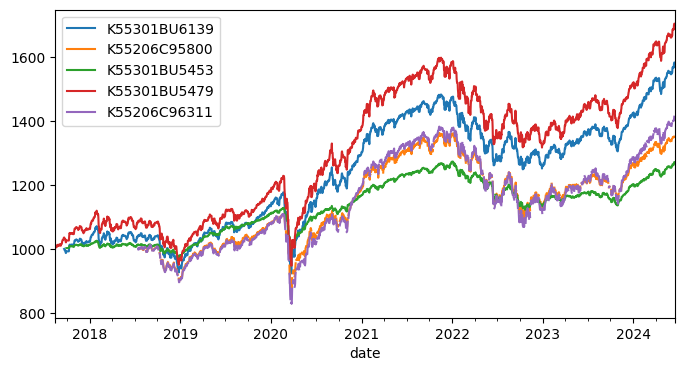

In [10]:
df_tdfs.plot(figsize=(8,4))

## ETF

In [11]:
file = 'etfs_selected_240611.csv'
df_etfs = pd.read_csv(f'{path_data}/{file}', parse_dates=[0], index_col=0)
df_etfs.head()

,273130,453850,284430,069500,379800,411060,305080,304660,148070,261220
Date,,,,,,,,,,
2002-10-14,NaN,NaN,NaN,5184,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-15,NaN,NaN,NaN,5312,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-16,NaN,NaN,NaN,5335,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-17,NaN,NaN,NaN,5410,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-18,NaN,NaN,NaN,5642,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_sym = fdr.StockListing('ETF/KR') # 한국 ETF 전종목

symbols = df_etfs.columns
etf_names = df_sym.loc[df_sym.Symbol.isin(symbols)].set_index('Symbol')['Name'].to_dict()
etf_names

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '379800': 'KODEX 미국S&P500TR',
 '453850': 'ACE 미국30년국채액티브(H)',
 '148070': 'KOSEF 국고채10년',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '284430': 'KODEX 200미국채혼합',
 '261220': 'KODEX WTI원유선물(H)'}

In [13]:
get_date_range(df_etfs)

,start date,end date
069500,2002-10-14,2024-06-11
148070,2011-10-20,2024-06-11
261220,2016-12-27,2024-06-11
273130,2017-06-29,2024-06-11
284430,2017-11-30,2024-06-11
305080,2018-08-30,2024-06-11
304660,2018-09-12,2024-06-11
379800,2021-04-09,2024-06-11
411060,2021-12-15,2024-06-11
453850,2023-03-14,2024-06-11


In [14]:
equity_names = etf_names.copy()
equity_names.update(tdf_names)

# Backtest

## Setting

In [15]:
{x: equity_names[x] for x in df_tdfs.columns}

{'K55301BU6139': '미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e',
 'K55206C95800': '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)',
 'K55301BU5453': '미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e',
 'K55301BU5479': '미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e',
 'K55206C96311': '키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)'}

In [16]:
cols = ['K55301BU6139', 'K55206C95800']
df1 = df_tdfs[cols]
[equity_names[x] for x in df1.columns]

['미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e',
 '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)']

In [17]:
{x:equity_names[x] for x in df_etfs.columns}

{'273130': 'KODEX 종합채권(AA-이상)액티브',
 '453850': 'ACE 미국30년국채액티브(H)',
 '284430': 'KODEX 200미국채혼합',
 '069500': 'KODEX 200',
 '379800': 'KODEX 미국S&P500TR',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '148070': 'KOSEF 국고채10년',
 '261220': 'KODEX WTI원유선물(H)'}

In [18]:
#cols = ['069500', '148070', '305080', '379800']
cols = ['069500', '273130', '148070', '379800']
df2 = df_etfs[cols]
{x:equity_names[x] for x in df2.columns}

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '148070': 'KOSEF 국고채10년',
 '379800': 'KODEX 미국S&P500TR'}

In [103]:
df = df1.join(df2, how='outer')

bts = Backtest(df, metrics=metrics, initial_capital=10000000,
               equity_names=equity_names, commissions=None)

backtest period reset: 2021-04-09 ~ 2024-06-11
rate of nan filled forward::
  K55301BU6139: 0.001
  K55206C95800: 0.478
  069500: 0.485
  273130: 0.485
  148070: 0.485
  379800: 0.485


Baseline

In [104]:
name = 'KOSPI'
ticker = '069500'
bts.buy_n_hold(ticker, name=name)

## TDF

In [105]:
tickers = ['K55301BU6139', 'K55206C95800']
weights = [0.5, 0.5]
weights = dict(zip(tickers, weights))

In [106]:
name = 'TDF COMB'
bts.build(weights, name, period='Y')

In [107]:
name = 'TDF COMB w/fee'
bts.build(weights, name, period='Y', commissions=commissions)

In [108]:
name = 'TDF COMB DCA'
bts.build(weights, name, period='M', 
          initial_capital=0, capital_flow=1000000)

In [109]:
name = 'TDF COMB DCA w/fee'
bts.build(weights, name, period='M', 
          initial_capital=0, capital_flow=1000000, commissions=commissions)

In [110]:
name = 'TDF COMB DCA2'
bts.build(weights, name, period='Q', 
          #initial_capital=0, 
          capital_flow=5000000, commissions=commissions)

## ETF

In [111]:
etfs = ['069500', '273130', '148070', '379800']
[equity_names[x] for x in etfs]

['KODEX 200', 'KODEX 종합채권(AA-이상)액티브', 'KOSEF 국고채10년', 'KODEX 미국S&P500TR']

In [112]:
name = 'ETF COMB1'
weights = [0.2, 0.2, 0.3, 0.3]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='Y')

In [113]:
name = 'ETF COMB2'
weights = [0.3, 0.2, 0.3, 0.2]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='Y')

## Compare

In [114]:
bts.get_weights()

,KOSPI,TDF COMB,TDF COMB w/fee,TDF COMB DCA,TDF COMB DCA w/fee,TDF COMB DCA2,ETF COMB1,ETF COMB2
069500,1.0,0.0,0.0,0.0,0.0,0.0,0.2,0.3
K55301BU6139,0.0,0.5,0.5,0.5,0.5,0.5,0.0,0.0
K55206C95800,0.0,0.5,0.5,0.5,0.5,0.5,0.0,0.0
273130,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2
148070,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.3
379800,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.2


,KOSPI,TDF COMB,TDF COMB w/fee,TDF COMB DCA,TDF COMB DCA w/fee,TDF COMB DCA2,ETF COMB1,ETF COMB2
start,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,-0.07205,0.095495,0.089502,0.080366,0.077757,0.075071,0.160406,0.091834
cagr,-0.02327,0.029135,0.027359,0.024638,0.023858,0.023054,0.047958,0.02805
max_drawdown,-0.342102,-0.174055,-0.174059,-0.166899,-0.167251,-0.158577,-0.141659,-0.16493
avg_drawdown,-0.085707,-0.016229,-0.016504,-0.016196,-0.014564,-0.011319,-0.01141,-0.013601
avg_drawdown_days,229.0,56.210526,56.578947,63.235294,56.842105,48.363636,34.129032,43.48
daily_vol,0.136883,0.052665,0.052722,0.050338,0.050339,0.046337,0.06132,0.063515
daily_sharpe,-0.050308,0.402564,0.379586,0.358775,0.348333,0.362538,0.557741,0.332261
daily_sortino,-0.079776,0.611235,0.576085,0.545526,0.529736,0.556782,0.867468,0.51778


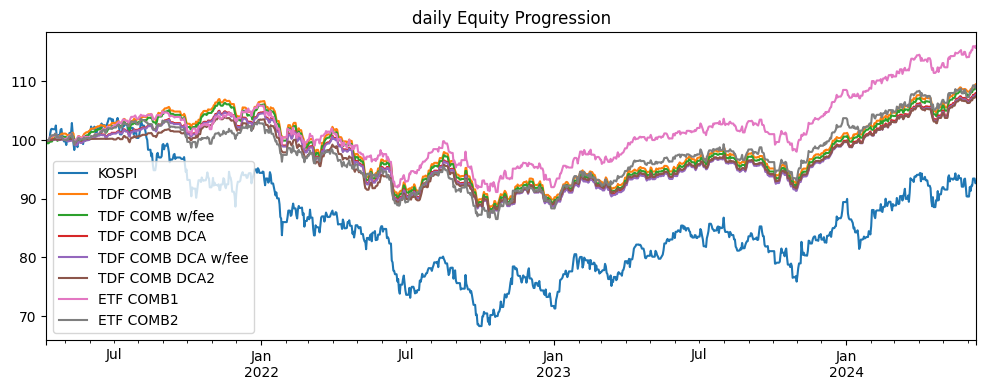

In [115]:
bts.run(figsize=(12,4))

,KOSPI,TDF COMB,TDF COMB w/fee,TDF COMB DCA,TDF COMB DCA w/fee,TDF COMB DCA2
start,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,-0.07205,0.095495,0.089502,0.080366,0.077757,0.075071
cagr,-0.02327,0.029135,0.027359,0.024638,0.023858,0.023054
max_drawdown,-0.342102,-0.174055,-0.174059,-0.166899,-0.167251,-0.158577
avg_drawdown,-0.085707,-0.016229,-0.016504,-0.016196,-0.014564,-0.011319
avg_drawdown_days,229.0,56.210526,56.578947,63.235294,56.842105,48.363636
daily_vol,0.136883,0.052665,0.052722,0.050338,0.050339,0.046337
daily_sharpe,-0.050308,0.402564,0.379586,0.358775,0.348333,0.362538
daily_sortino,-0.079776,0.611235,0.576085,0.545526,0.529736,0.556782


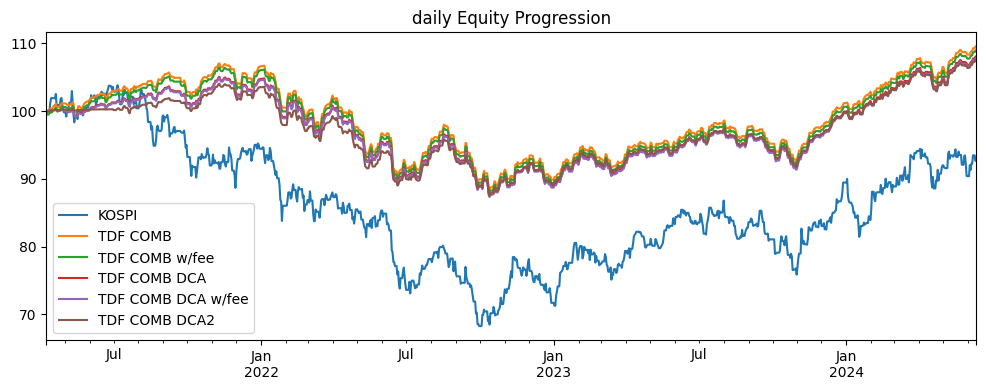

In [70]:
bts.run(range(6), figsize=(12,4))

In [71]:
{i:x for i,x in enumerate(bts.portfolios.keys())}

{0: 'KOSPI',
 1: 'TDF COMB',
 2: 'TDF COMB w/fee',
 3: 'TDF COMB DCA',
 4: 'TDF COMB DCA w/fee',
 5: 'TDF COMB DCA2',
 6: 'ETF COMB1',
 7: 'ETF COMB2'}

,KOSPI,TDF COMB,TDF COMB DCA,TDF COMB DCA2,ETF COMB1,ETF COMB2
start,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,-0.07205,0.095495,0.080366,0.075071,0.160406,0.091834
cagr,-0.02327,0.029135,0.024638,0.023054,0.047958,0.02805
max_drawdown,-0.342102,-0.174055,-0.166899,-0.158577,-0.141659,-0.16493
avg_drawdown,-0.085707,-0.016229,-0.016196,-0.011319,-0.01141,-0.013601
avg_drawdown_days,229.0,56.210526,63.235294,48.363636,34.129032,43.48
daily_vol,0.136883,0.052665,0.050338,0.046337,0.06132,0.063515
daily_sharpe,-0.050308,0.402564,0.358775,0.362538,0.557741,0.332261
daily_sortino,-0.079776,0.611235,0.545526,0.556782,0.867468,0.51778


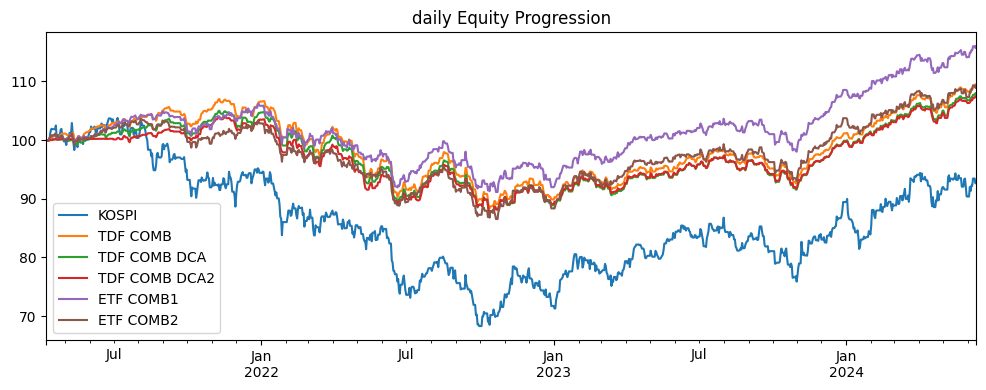

In [72]:
bts.run([0,1,3,5,6,7], figsize=(12,4))

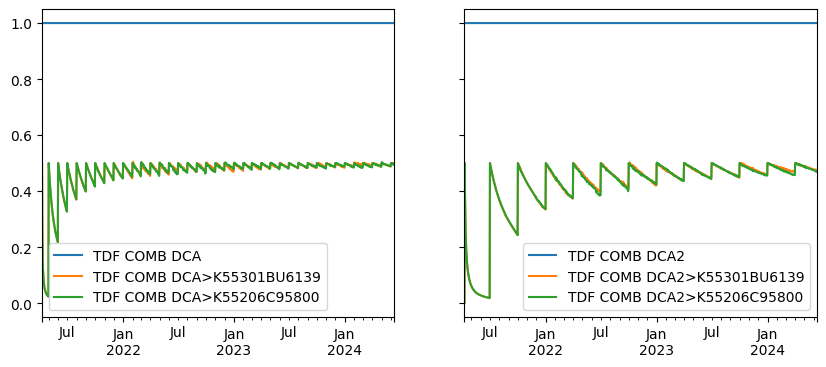

In [34]:
bts.plot_weights([2,3], figsize=(10,4))

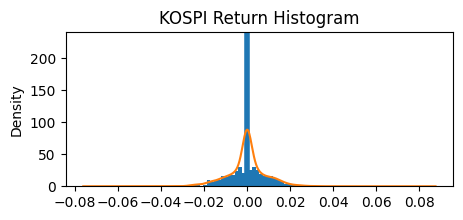

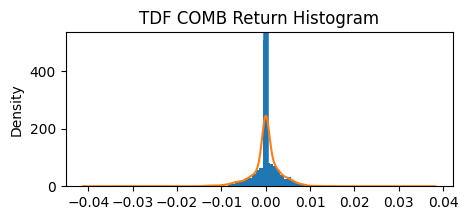

In [35]:
bts.plot_histogram([0,1], bins=50, figsize=(5,2))

# Scaled

## Data

In [45]:
etfs = ['069500', '273130', '148070', '379800']
{x: etf_names[x] for x in etfs}

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '148070': 'KOSEF 국고채10년',
 '379800': 'KODEX 미국S&P500TR'}

In [46]:
get_date_range(df_etfs[etfs])

,start date,end date
069500,2002-10-14,2024-06-11
148070,2011-10-20,2024-06-11
273130,2017-06-29,2024-06-11
379800,2021-04-09,2024-06-11


In [47]:
start_date = '2017-06-29'

In [48]:
df_snp = fdr.DataReader('S&P500')
df_snp = df_snp['Adj Close']
df_rate = df_snp/df_snp[0]-1
df_rate

Date
1980-01-02     0.000000
1980-01-03    -0.005106
1980-01-04     0.007186
1980-01-07     0.009928
1980-01-08     0.030163
                ...    
2024-06-11    49.825640
2024-06-12    50.257845
2024-06-13    50.378027
2024-06-14    50.357791
2024-06-17    50.290846
Name: Adj Close, Length: 11209, dtype: float64

In [49]:
df_379800 = df_etfs['379800'].dropna()
df_379800.head()
#df_379800.tail()

Date
2021-04-09    10085.0
2021-04-12    10155.0
2021-04-13    10190.0
2021-04-14    10145.0
2021-04-15    10130.0
Name: 379800, dtype: float64

In [50]:
file = '금융자산운용 - export.csv'
df_info = pd.read_csv(f'{path_data}/{file}')
df_info.iloc[-1]

name            KODEX 미국S&P500TR assumed from S&P500 rate of r...
ticker                                                   379800_R
commission                                                    0.0
data_type                                                      -1
file                                                     379800_R
check1_date                                            2024-06-11
check1_price                                              16770.0
check2_date                                            2021-04-09
check2_price                                              10085.0
Name: 5, dtype: object

In [51]:
data = df_info.iloc[-1]
df_379800r = convert_rate_to_price(data, rate_is_percent=False, df_rate=df_rate)
df_379800r

error: 27.73 %


date
1980-01-02      329.951573
1980-01-03      328.266871
1980-01-04      332.322617
1980-01-07      333.227366
1980-01-08      339.903766
                  ...     
2024-06-11    16770.000000
2024-06-12    16912.606593
2024-06-13    16952.260834
2024-06-14    16945.584007
2024-06-17    16923.495478
Name: 379800_R, Length: 11209, dtype: float64

<Axes: xlabel='Date'>

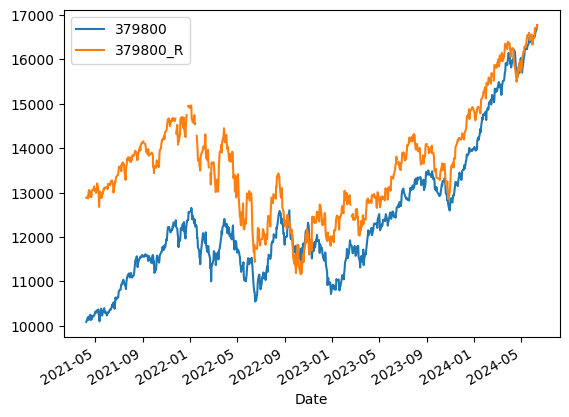

In [52]:
df_379800.to_frame().join(df_379800r).plot()

In [53]:
etfs = ['069500', '273130', '148070']
df = df_etfs[etfs].join(df_379800r).loc[start_date:]
df

,069500,273130,148070,379800_R
Date,,,,
2017-06-29,27193,99855.0,106044.0,7549.014665
2017-06-30,27109,99810.0,105817.0,7560.589054
2017-07-03,27170,99745.0,105613.0,7578.060320
2017-07-04,27002,99655.0,105190.0,NaN
2017-07-05,27105,99620.0,105253.0,7589.073356
...,...,...,...,...
2024-06-04,36390,110605.0,111850.0,16507.998052
2024-06-05,36755,110820.0,112200.0,16703.579031
2024-06-07,37240,111075.0,112610.0,16681.616938


In [54]:
ticker = '379800_R'
etf_names.update({ticker:'KODEX 미국S&P500TR assumed from S&P500 rate of return'})
etfs.append(ticker)

## Backtest

In [55]:
bts = Backtest(df, metrics=metrics, initial_capital=10000000,
               equity_names=etf_names, commissions=None)

backtest period reset: 2017-06-29 ~ 2024-06-11
rate of nan filled forward::
  069500: 0.000
  273130: 0.000
  148070: 0.000
  379800_R: 0.033


In [56]:
name = 'KOSPI'
ticker = '069500'
bts.buy_n_hold(ticker, name=name)

In [57]:
{x:etf_names[x] for x in etfs}

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '148070': 'KOSEF 국고채10년',
 '379800_R': 'KODEX 미국S&P500TR assumed from S&P500 rate of return'}

In [58]:
name = 'ETF COMB1'
weights = [0.2, 0.2, 0.3, 0.3]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='Y')

In [59]:
name = 'ETF COMB1 (M)'
weights = [0.2, 0.2, 0.3, 0.3]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='M', capital_flow=1000000)

In [60]:
name = 'ETF COMB2'
weights = [0.3, 0.2, 0.3, 0.2]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='Y')

,KOSPI,ETF COMB1,ETF COMB1 (M),ETF COMB2
start,2017-06-28 00:00:00,2017-06-28 00:00:00,2017-06-28 00:00:00,2017-06-28 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,0.359183,0.450954,0.430813,0.383078
cagr,0.045118,0.054983,0.052865,0.04774
max_drawdown,-0.380162,-0.189178,-0.190569,-0.20192
avg_drawdown,-0.047992,-0.012449,-0.012622,-0.015412
avg_drawdown_days,94.576923,26.809524,27.47561,39.288136
daily_vol,0.184222,0.078006,0.078233,0.077309
daily_sharpe,0.337775,0.743129,0.714828,0.657651
daily_sortino,0.555855,1.165093,1.118762,1.04768


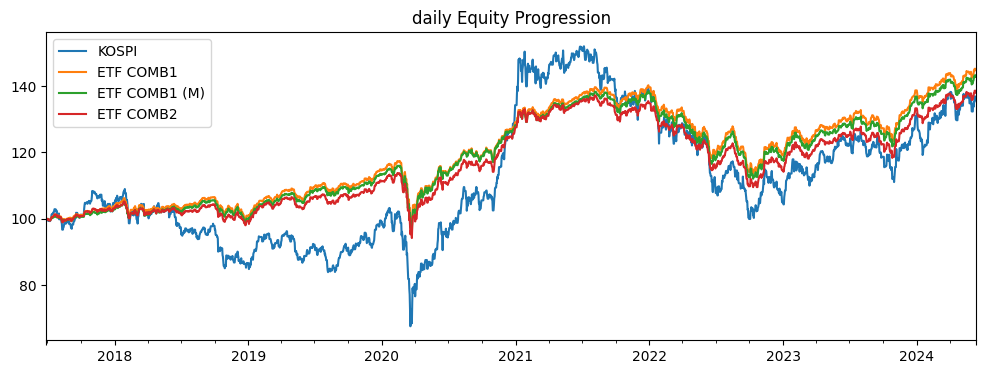

In [61]:
bts.run(figsize=(12,4))

In [82]:
bts.show_weights('ETF COMB1')

KODEX 200                                              0.2
KODEX 종합채권(AA-이상)액티브                                   0.2
KOSEF 국고채10년                                           0.3
KODEX 미국S&P500TR assumed from S&P500 rate of return    0.3
dtype: float64

In [83]:
bts.show_weights('ETF COMB2')

KODEX 200                                              0.3
KODEX 종합채권(AA-이상)액티브                                   0.2
KOSEF 국고채10년                                           0.3
KODEX 미국S&P500TR assumed from S&P500 rate of return    0.2
dtype: float64

# Bayesian

## Portfolios

In [16]:
{x:equity_names[x] for x in df_etfs.columns}

{'273130': 'KODEX 종합채권(AA-이상)액티브',
 '453850': 'ACE 미국30년국채액티브(H)',
 '284430': 'KODEX 200미국채혼합',
 '069500': 'KODEX 200',
 '379800': 'KODEX 미국S&P500TR',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '148070': 'KOSEF 국고채10년',
 '261220': 'KODEX WTI원유선물(H)'}

In [17]:
name = 'KOSPI'
tickers = ['069500']
weights = [1]

pfs = list()
kwa = {'name': name, 'weights': dict(zip(tickers, weights))}
pfs.append(kwa)

[equity_names[x] for x in df_etfs[tickers].columns]

['KODEX 200']

In [18]:
{x: equity_names[x] for x in df_tdfs.columns}

{'K55301BU6139': '미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e',
 'K55206C95800': '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)',
 'K55301BU5453': '미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e',
 'K55301BU5479': '미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e',
 'K55206C96311': '키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)'}

In [19]:
name = 'TDF COMB'
tickers = ['K55301BU6139', 'K55206C95800']
weights = [0.5, 0.5]
kwa = {'name': name, 'weights': dict(zip(tickers, weights))}
pfs.append(kwa)
[equity_names[x] for x in df_tdfs[tickers].columns]

['미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e',
 '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)']

In [20]:
tickers = ['K55301BU6139']
name = tickers[0]
weights = [1]
kwa = {'name': name, 'weights': dict(zip(tickers, weights))}
pfs.append(kwa)
[equity_names[x] for x in df_tdfs[tickers].columns]

['미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e']

In [21]:
tickers = ['K55206C95800']
name = tickers[0]
weights = [1]
kwa = {'name': name, 'weights': dict(zip(tickers, weights))}
pfs.append(kwa)
[equity_names[x] for x in df_tdfs[tickers].columns]

['키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)']

## Backtest

In [22]:
df = df_etfs.join(df_tdfs, how='outer')

bts = Backtest(df, metrics=metrics, initial_capital=10000000,
               equity_names=etf_names, commissions=None)

In [23]:
bts.build_batch(pfs, freq='Y', fill_na=False, reset_portfolios=True)

period reset: 2002-10-14 ~ 2024-06-11
ratio of nan dropped::
  069500: 0.153
period reset: 2018-07-26 ~ 2024-06-13
ratio of nan dropped::
  K55301BU6139: 0.000
  K55206C95800: 0.478
period reset: 2017-09-20 ~ 2024-06-16
ratio of nan dropped::
  K55301BU6139: 0.000
period reset: 2018-07-26 ~ 2024-06-13
ratio of nan dropped::
  K55206C95800: 0.478


,KOSPI,TDF COMB,K55301BU6139,K55206C95800
start,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,0.416803,0.419821,0.501756,0.346793
cagr,0.061033,0.061417,0.071592,0.051929
max_drawdown,-0.346464,-0.215628,-0.215087,-0.219971
avg_drawdown,-0.052969,-0.016192,-0.014093,-0.017237
avg_drawdown_days,82.2,34.333333,27.171429,34.690909
daily_mean,0.079401,0.063613,0.07536,0.05602
daily_vol,0.193239,0.070285,0.094036,0.090421
daily_sharpe,0.410894,0.905076,0.801393,0.619546


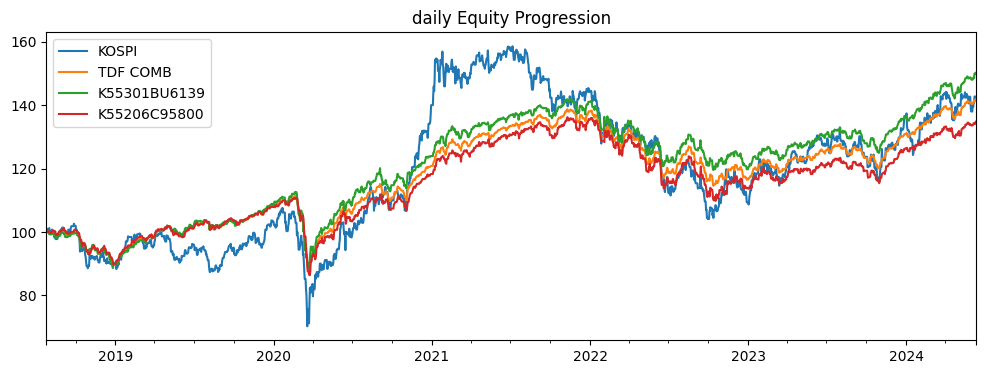

In [24]:
bts.run(figsize=(12,4))

In [25]:
df = bts.get_historical()
#df = df.iloc[:, 1:].dropna()
df.head()

,KOSPI,TDF COMB,K55301BU6139,K55206C95800
2002-10-14,100.000000,NaN,NaN,NaN
2002-10-15,102.469152,NaN,NaN,NaN
2002-10-16,102.912827,NaN,NaN,NaN
2002-10-17,104.359596,NaN,NaN,NaN
2002-10-18,108.834933,NaN,NaN,NaN


## Estimate

In [33]:
ae = AssetEvaluator(df.iloc[:,:2])
#ae = AssetEvaluator(df)
ae.summary(freq='yearly', align_period=False)

,KOSPI,TDF COMB
years,21.2,5.7
cagr,0.09689,0.016799
yearly_mean,0.096147,0.068969
yearly_vol,0.252752,0.118083
yearly_sharpe,0.380402,0.584076


In [34]:
ae.summary(freq='yearly', align_period=True)

period reset: 2018-07-26 ~ 2024-06-11
ratio of nan dropped::
  KOSPI: 0.000
  TDF COMB: 0.001


,KOSPI,TDF COMB
years,5.7,5.7
cagr,0.061406,0.063673
yearly_mean,0.096196,0.069036
yearly_vol,0.252678,0.118205
yearly_sharpe,0.380704,0.584032


In [37]:
df_tmp = ae.df_prices['TDF COMB'].dropna()
df_tmp

date
2018-07-26    100.000000
2018-07-27    100.012788
2018-07-30     99.934898
2018-07-31     99.594990
2018-08-01     99.595473
                 ...    
2024-06-04    141.245940
2024-06-05    141.376876
2024-06-07    142.093348
2024-06-10    142.378536
2024-06-11    142.469462
Name: TDF COMB, Length: 1445, dtype: float64

In [ ]:
df_tmp[-1]/df_tmp[-1]

In [94]:
#ae.bayesian_sample(freq='yearly', align_period=True)
#ae.bayesian_sample_old(freq='yearly')
ae.bayesian_sample(freq='yearly')

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:11

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [95]:
var_names = ['_mean', '_sharpe']
ae.bayesian_summary(var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
yearly_mean[KOSPI],0.112,0.003,0.106,0.117,0.0,0.0,6092.0,3087.0,1.0
yearly_mean[TDF COMB],0.068,0.003,0.062,0.075,0.0,0.0,5394.0,2834.0,1.0
yearly_mean[K55301BU6139],0.064,0.003,0.058,0.070,0.0,0.0,7790.0,2981.0,1.0
yearly_mean[K55206C95800],0.058,0.004,0.052,0.065,0.0,0.0,5997.0,2900.0,1.0
yearly_sharpe[KOSPI],0.502,0.015,0.473,0.531,0.0,0.0,6441.0,2881.0,1.0
yearly_sharpe[TDF COMB],0.576,0.031,0.518,0.636,0.0,0.0,5685.0,2871.0,1.0
yearly_sharpe[K55301BU6139],0.555,0.029,0.498,0.608,0.0,0.0,7715.0,3168.0,1.0
yearly_sharpe[K55206C95800],0.484,0.031,0.427,0.541,0.0,0.0,6102.0,2888.0,1.0


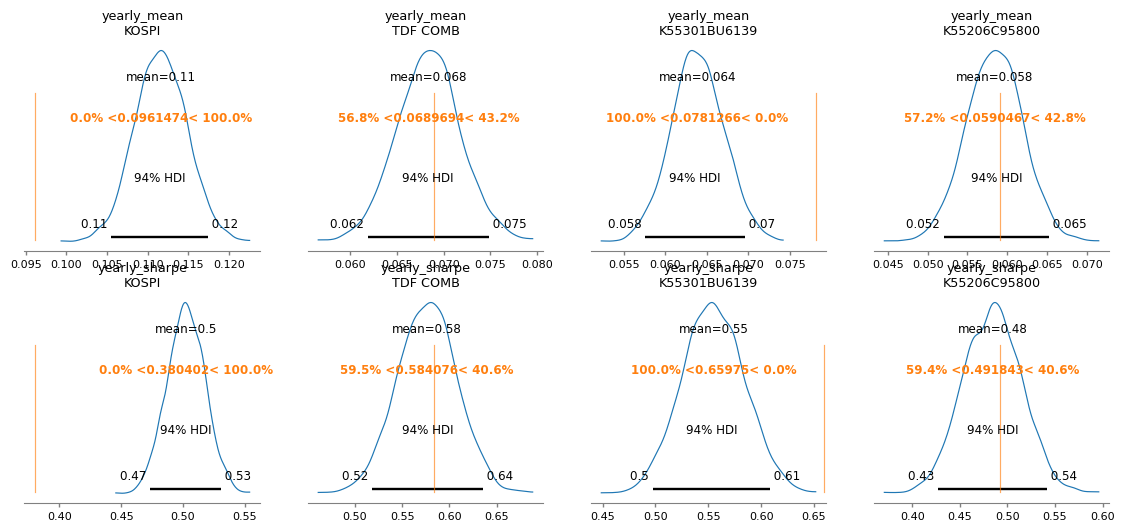

In [96]:
ae.bayesian_plot(var_names, figsize=(14,6), textsize=8)

In [97]:
ae.bayesian_sample(freq='yearly', align_period=True)
ae.bayesian_summary(var_names)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:07

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
yearly_mean[KOSPI],0.091,0.007,0.078,0.106,0.0,0.0,6033.0,2349.0,1.0
yearly_mean[TDF COMB],0.069,0.003,0.062,0.075,0.0,0.0,8281.0,2925.0,1.0
yearly_mean[K55301BU6139],0.078,0.003,0.071,0.084,0.0,0.0,6975.0,2910.0,1.0
yearly_mean[K55206C95800],0.059,0.003,0.052,0.065,0.0,0.0,7838.0,3080.0,1.0
yearly_sharpe[KOSPI],0.363,0.030,0.309,0.422,0.0,0.0,6528.0,2426.0,1.0
yearly_sharpe[TDF COMB],0.578,0.032,0.519,0.638,0.0,0.0,8458.0,2835.0,1.0
yearly_sharpe[K55301BU6139],0.653,0.031,0.595,0.712,0.0,0.0,7182.0,3140.0,1.0
yearly_sharpe[K55206C95800],0.485,0.030,0.429,0.540,0.0,0.0,7314.0,3084.0,1.0


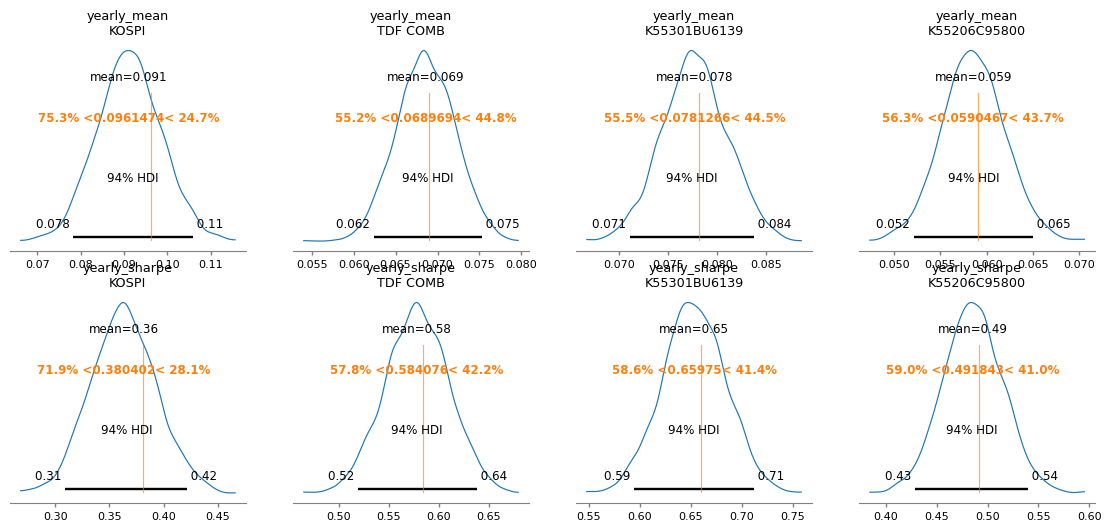

In [98]:
ae.bayesian_plot(var_names, figsize=(14,6), textsize=8)

In [56]:
ae.df_prices.pct_change().ffill().bfill().mean()

KOSPI           0.000458
TDF COMB        0.000162
K55301BU6139   -0.000880
K55206C95800    0.000790
dtype: float64

In [58]:
ae.df_prices.ffill().bfill().pct_change().mean()

KOSPI           0.000454
TDF COMB        0.000069
K55301BU6139    0.000089
K55206C95800    0.000060
dtype: float64

In [57]:
ae.df_prices.pct_change().dropna().mean()

KOSPI           0.000310
TDF COMB        0.000255
K55301BU6139    0.000296
K55206C95800    0.000222
dtype: float64